# COVID-19 Geography
## Liana Manuel 
This dataset shows the number of people who are at high risk of severe illness from COVID-19. It includes data from the Centers for Disease Control and Prevention's (CDC) Behavioral Risk Factor Surveillance System (BRFSS) along with information about metropolitan areas, micropolitan areas, and metropolitan divisions from the Kaiser Family Foundation. 

The CDC defines high risk as: 
- Older adults, particularly individuals over 85 years
- People with pre-existing medical conditions (eg. individuals with cancer, chronic kidney disease, COPD, heart conditions, immunocompromised state, obesity, etc.)

For more information, visit the website [here](https://github.com/fivethirtyeight/data/tree/master/covid-geography).

In [2]:
library('tidyverse')
library('lubridate')
library('patchwork')
library('ggrepel')

In [3]:
covid <- read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/covid-geography/mmsa-icu-beds.csv", 
                 col_types = cols(
                  MMSA = col_character(),
                  total_percent_at_risk = col_character(),
                  high_risk_per_ICU_bed = col_double(),
                  high_risk_per_hospital = col_double(),
                  icu_beds = col_double(),
                  hospitals = col_double(),
                  total_at_risk = col_double()
        ))

covid %>% head

MMSA,total_percent_at_risk,high_risk_per_ICU_bed,high_risk_per_hospital,icu_beds,hospitals,total_at_risk
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"San Juan-Carolina-Caguas, PR",52.88%,NA,NA,NA,NA,923725.20
"Manhattan, KS",47.29%,4489.849,8979.698,8,4,35918.79
"Hilton Head Island-Bluffton-Beaufort, SC",62.72%,3904.164,36438.860,28,3,109316.58
"Kahului-Wailuku-Lahaina, HI",59.13%,3860.557,19302.785,20,4,77211.14
"Spartanburg, SC",66.12%,3786.116,85187.600,45,2,170375.20
"Baton Rouge, LA",66.60%,3459.733,39000.621,124,11,429006.83


In [4]:
# clean data: create new columns for city, state and metro_division, convert total_percent_at_risk to numeric
# only keep MMSAs serving one state, and exclude PR
covid_rev <- covid %>% 
    mutate(MMSA2 = MMSA) %>%
    separate(., col = MMSA, into = c("City", "State", "Metro_division") , sep = ",") %>%
    mutate(City = str_trim(City),
           State = str_trim(State),
           Metro_division = str_trim(Metro_division),
           total_percent_at_risk2 = as.numeric(str_remove(total_percent_at_risk,"%"))) %>% 
    filter(!str_detect(State, "-"), !State == "PR") 

Warning message:
“Expected 3 pieces. Missing pieces filled with `NA` in 119 rows [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, ...].”


Note: For the purposes of this analysis, I will only focus on micropolitan areas or metropolitan divisions (MMSAs) serving a single state, and will exclude Puerto Rico. 

### Which cities have the highest percentage of individuals that are at high risk of severe COVID-19, per CDC's BRFSS?

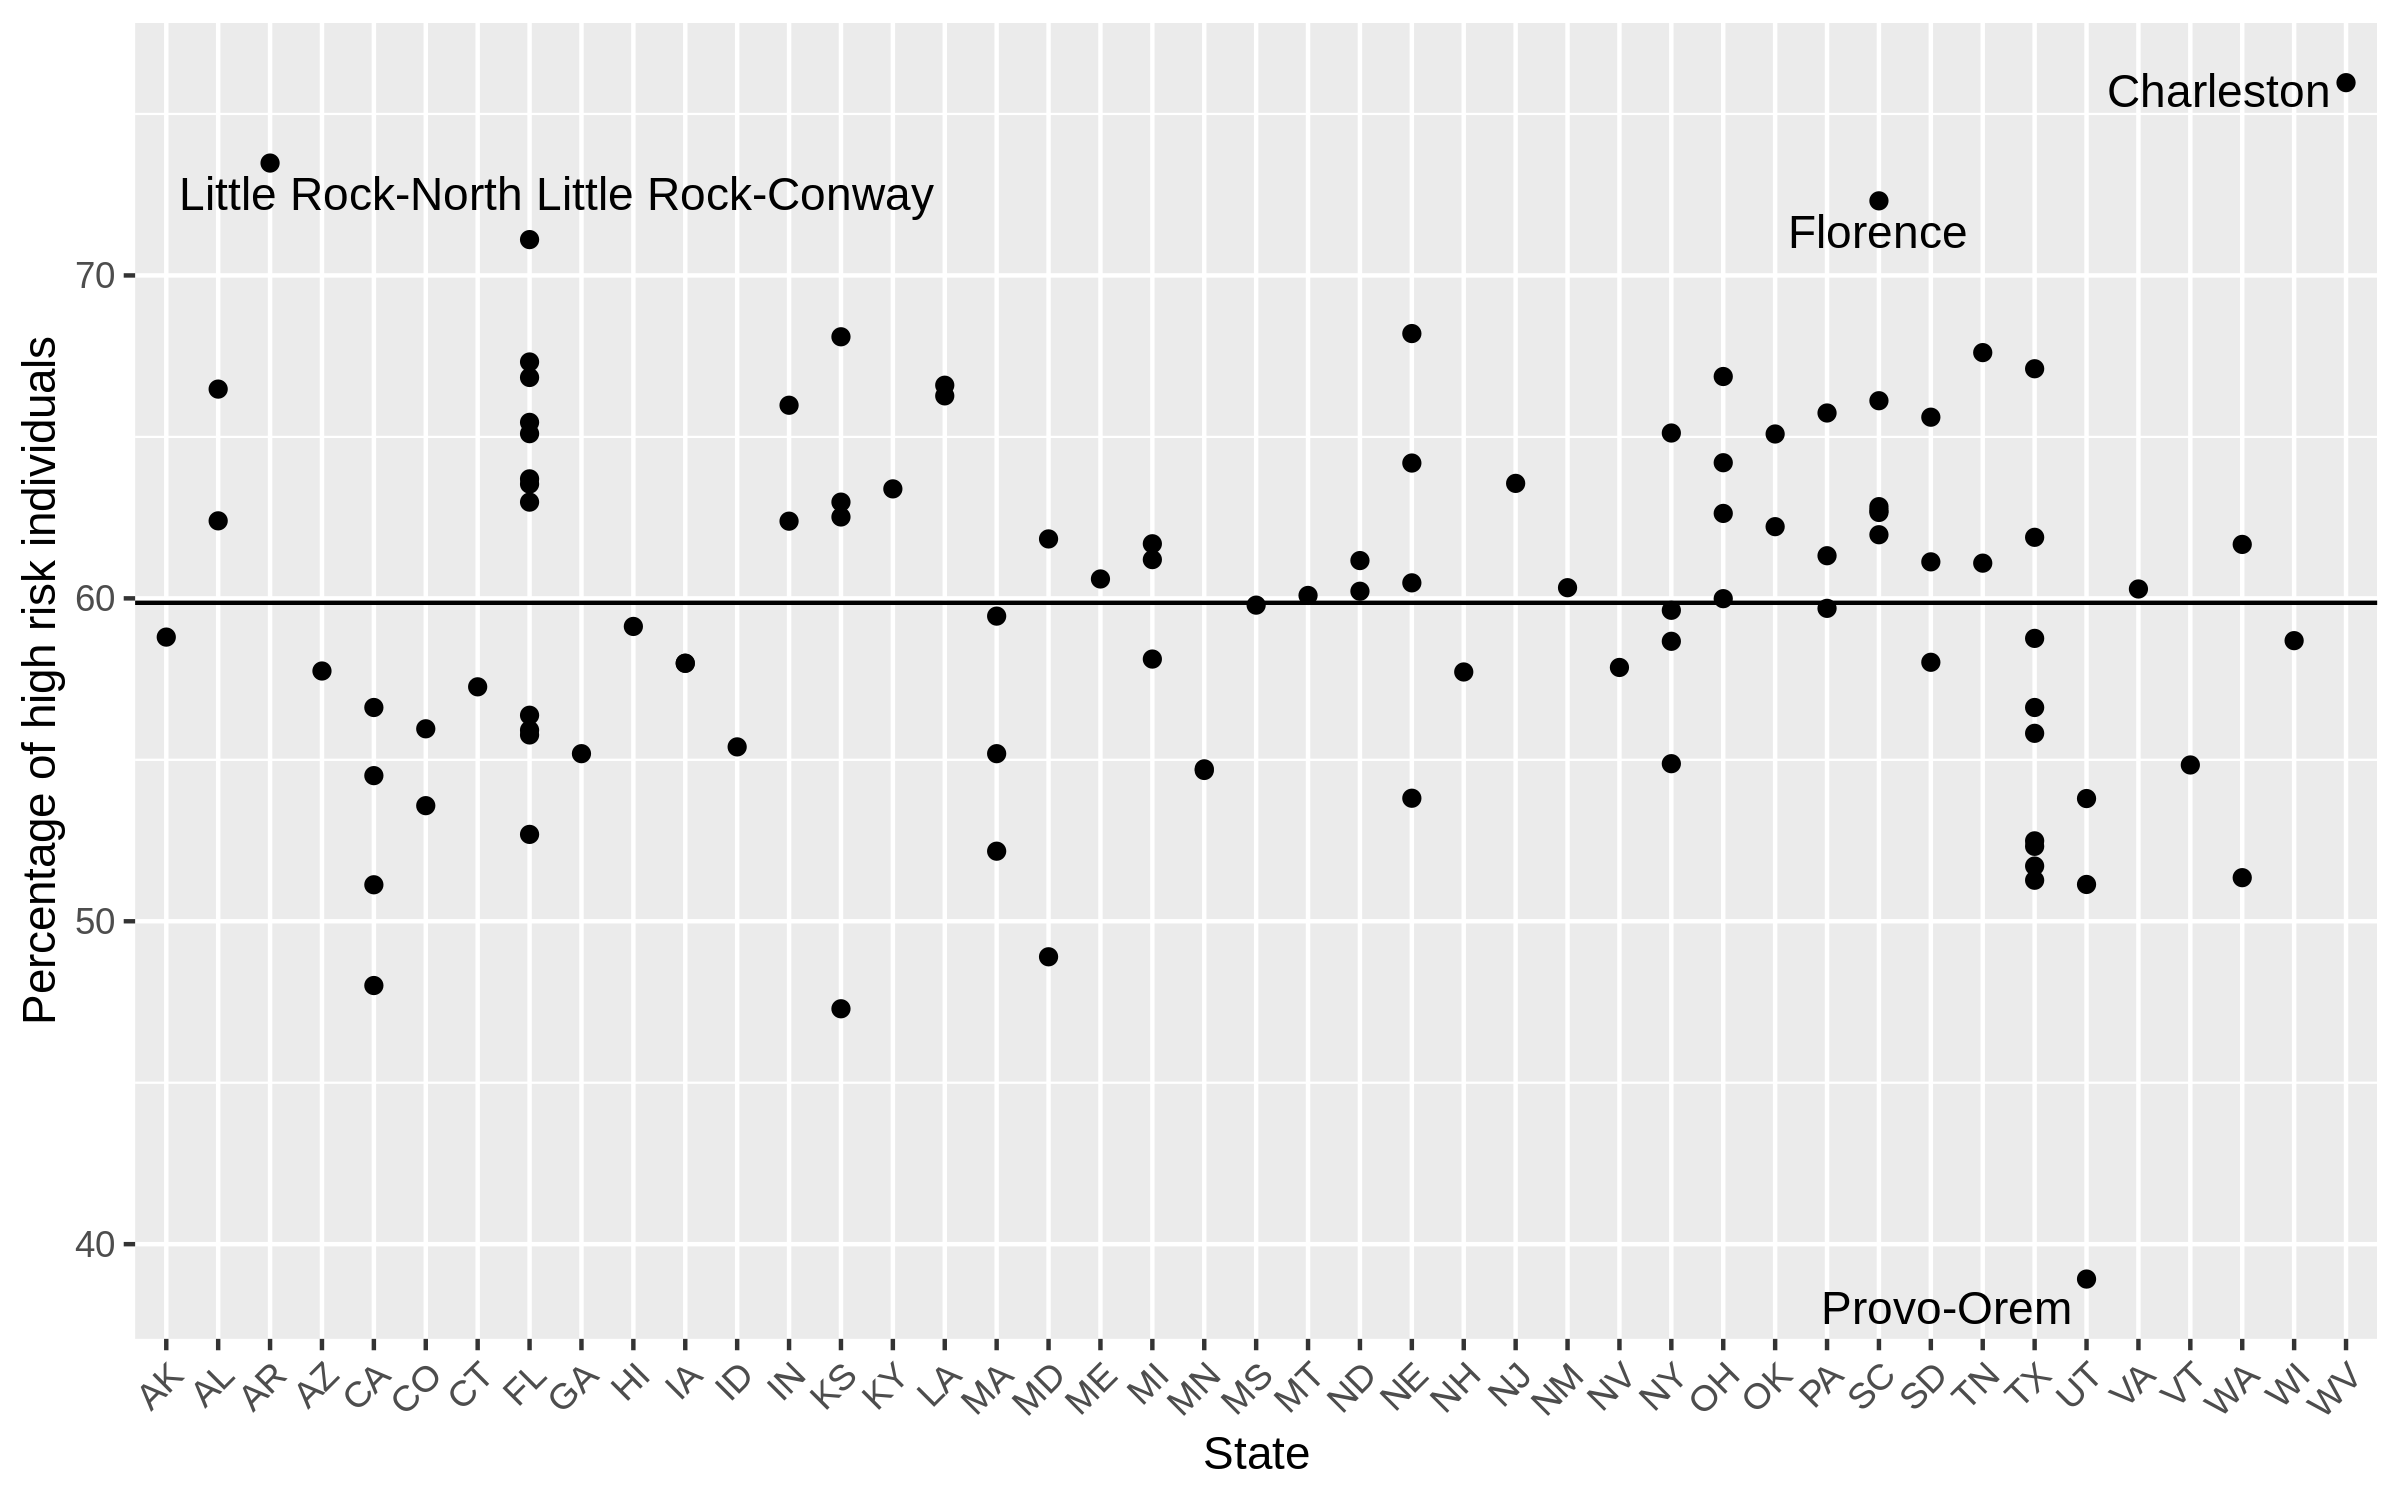

In [5]:
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res=300)
# covid_rev %>% summarize(mean = mean(total_percent_at_risk2))

covid_rev %>%    
    group_by(State) %>%
    ggplot(., aes(x = State, y = total_percent_at_risk2)) + 
    geom_point() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    labs(y = "Percentage of high risk individuals") + 
    geom_text_repel(data = covid_rev %>% filter(total_percent_at_risk2 > 72 | total_percent_at_risk2 < 40), 
              aes(label=City), hjust=0, vjust=0) + 
    geom_hline(yintercept = 59.86192)

In [6]:
# top 3
covid_rev %>% 
    group_by(State) %>% 
    select(City, State, total_percent_at_risk2, total_percent_at_risk, high_risk_per_ICU_bed, high_risk_per_hospital) %>% 
    arrange(desc(total_percent_at_risk2)) %>% head(3)

City,State,total_percent_at_risk2,total_percent_at_risk,high_risk_per_ICU_bed,high_risk_per_hospital
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
Charleston,WV,75.97,75.97%,831.6897,25948.72
Little Rock-North Little Rock-Conway,AR,73.48,73.48%,1664.5261,37830.14
Florence,SC,72.31,72.31%,1040.4632,22890.19


COVID-19 poses a risk throughout the U.S. and across the world, however the plot above highlights which U.S. cities may be particularly vulnerable. The regions with highest percentages of high risk individuals include: 1) Charleston, West Virgina (76%), 2) Little Rock, North Little Rock and Conway, Arkansas (73%), and 3) Florence, South Carolina (72%). Among the MMSAs recorded in the CDC's BRFSS, the average percentage of high risk individuals in an area is 60%, and the vast majority of the cities having between 50% and 70% high risk individuals. In comparison, Provo-Orem, Utah, has the lowest percentage of high risk individuals (39%). 

### Further investigate Charleston (WV), Little Rock (AR), and Florence (SC)

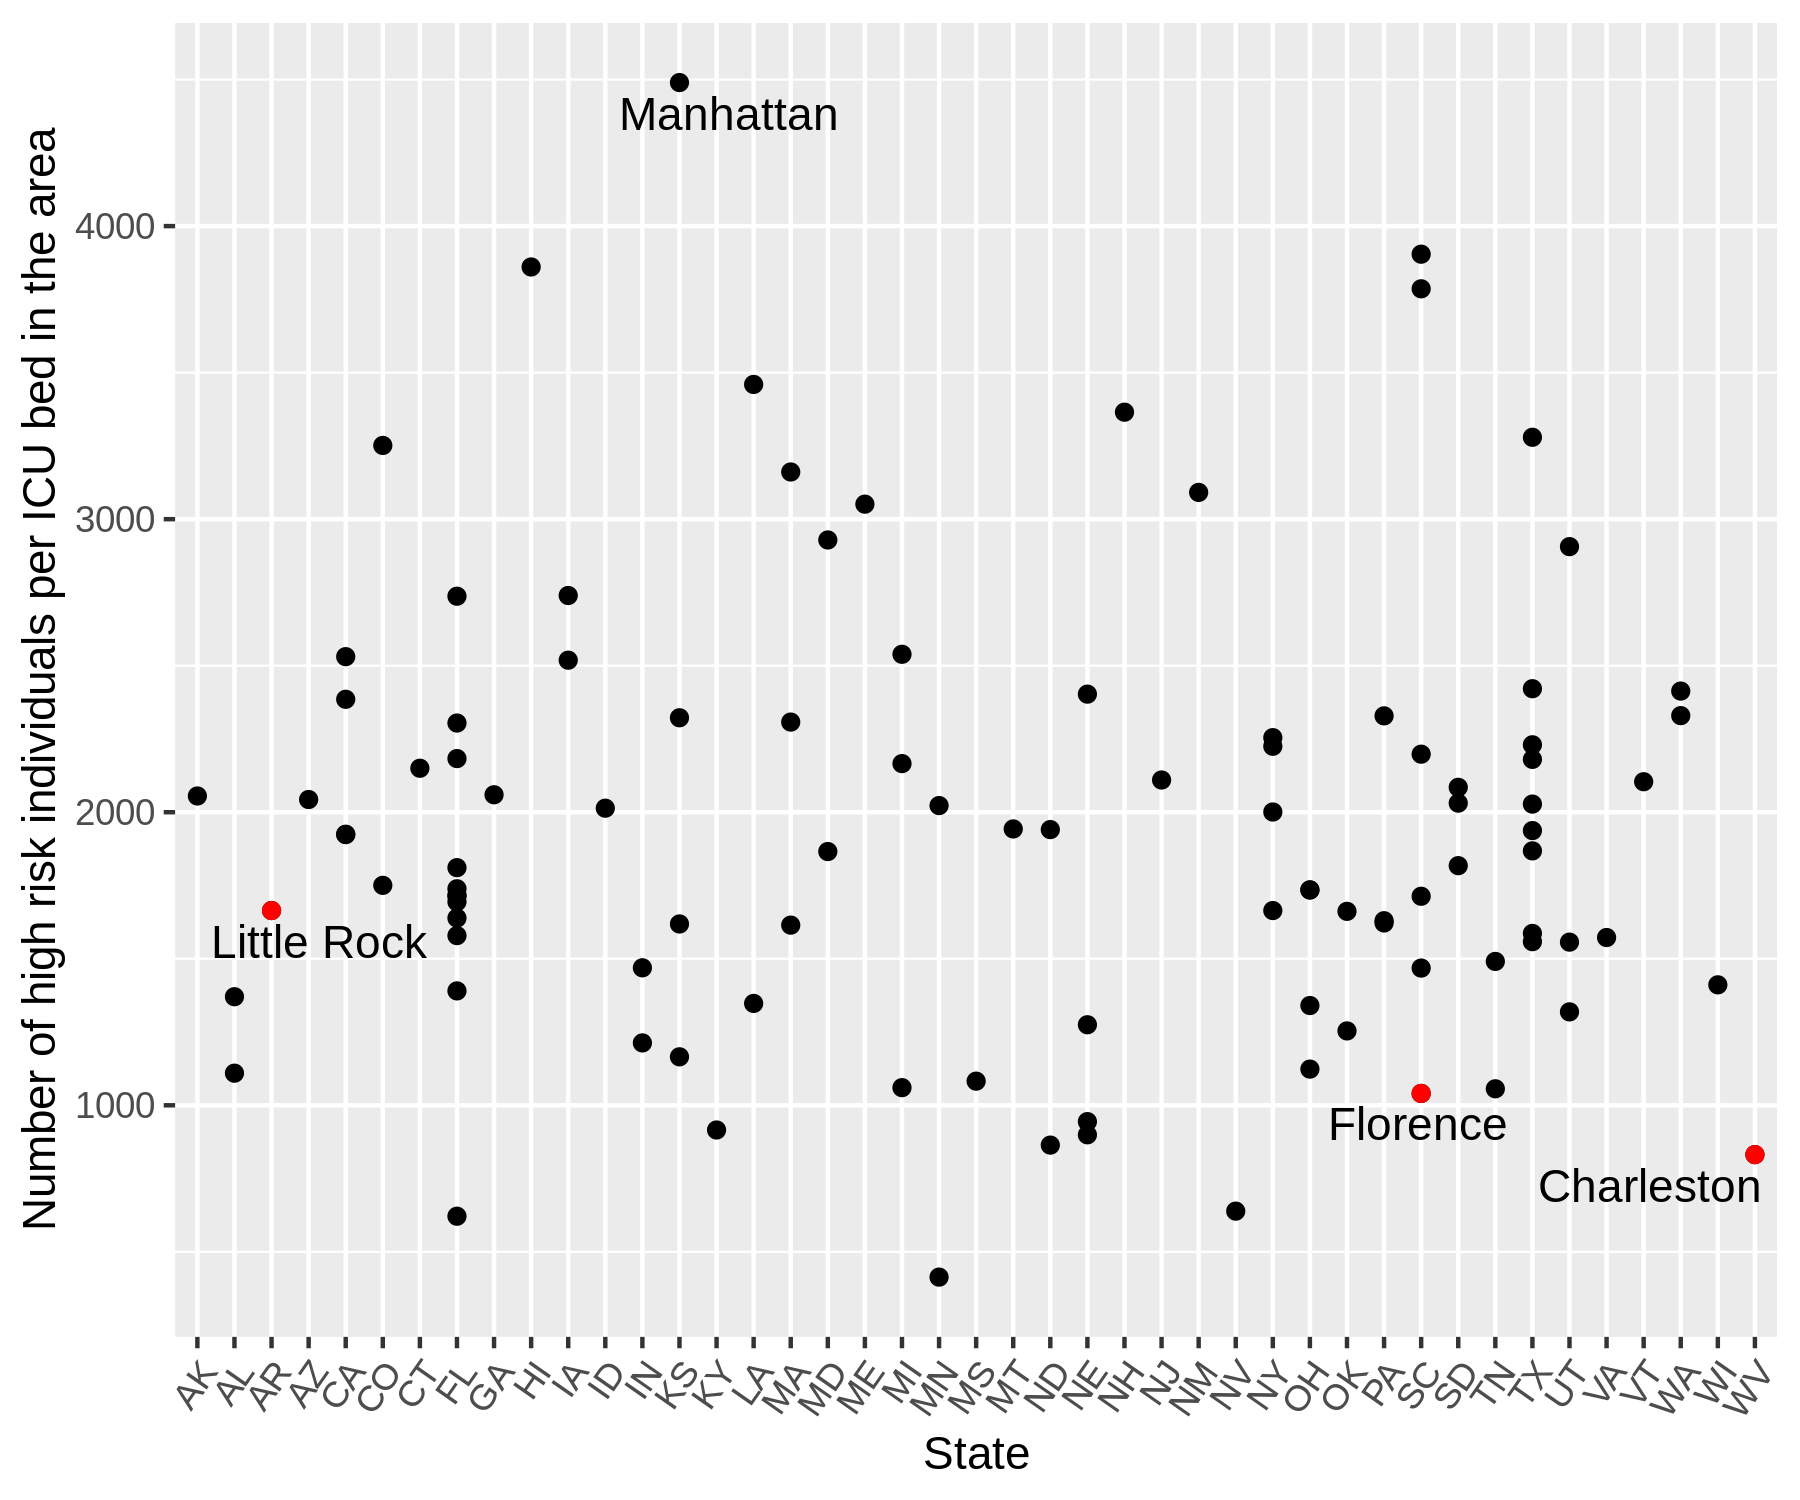

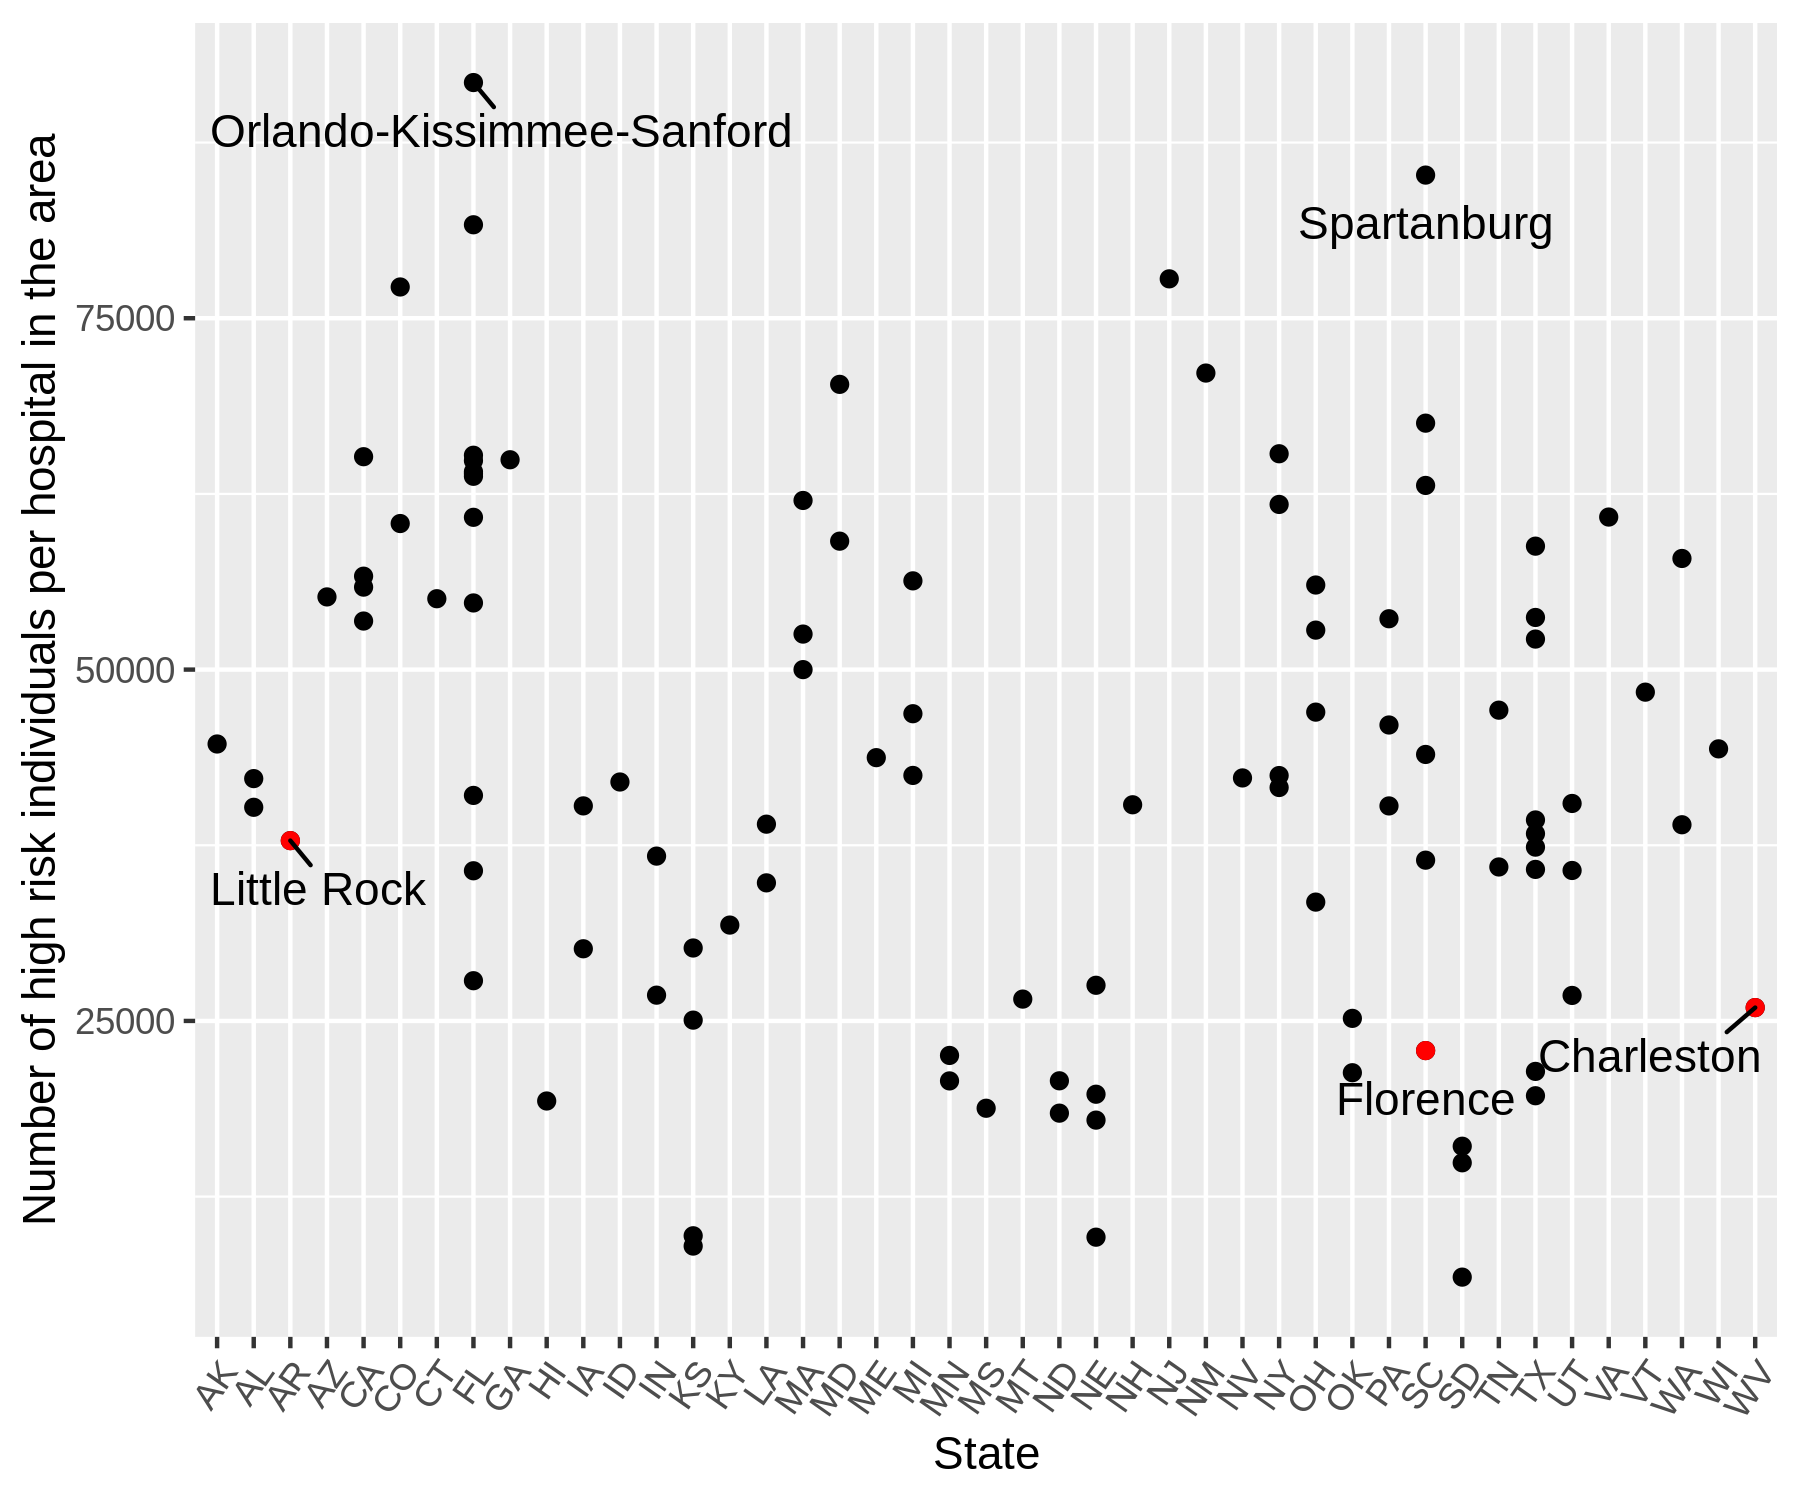

In [9]:
options(repr.plot.width=6, repr.plot.height=5, repr.plot.res=300)

# plot of number of high risk individuals per ICU bed in the area
icu <- covid_rev %>% 
    ggplot(., aes(x = State, y = high_risk_per_ICU_bed)) + 
    geom_point() + 
    geom_point(data = covid_rev %>% 
                   filter(City %in% c("Charleston", "Little Rock-North Little Rock-Conway", "Florence")),
               color = 'red') + 
    theme(axis.text.x = element_text(angle = 55, hjust = 1)) + 
    labs(y = "Number of high risk individuals per ICU bed in the area") + 
    geom_text_repel(data = covid_rev %>% 
                        filter(City %in% c("Charleston", "Little Rock-North Little Rock-Conway", "Florence") | high_risk_per_ICU_bed > 4000)  %>%
                        mutate(City = ifelse(City == "Little Rock-North Little Rock-Conway", "Little Rock", City)), 
              aes(label=City), hjust=0, vjust=0) 

# plot of number of high risk individuals per hospital in the area
hosp <- covid_rev %>% 
    group_by(State) %>%
    ggplot(., aes(x = State, y = high_risk_per_hospital)) + 
    geom_point() + 
    geom_point(data = covid_rev %>% filter(City %in% c("Charleston", "Little Rock-North Little Rock-Conway", "Florence")),
               color = 'red') + 
    theme(axis.text.x = element_text(angle = 55, hjust = 1)) + 
    labs(y = "Number of high risk individuals per hospital in the area") + 
    geom_text_repel(data = covid_rev %>% 
                        filter(City %in% c("Charleston", "Little Rock-North Little Rock-Conway", "Florence") | high_risk_per_hospital > 85000) %>%
                        mutate(City = ifelse(City == "Little Rock-North Little Rock-Conway", "Little Rock", City)), 
              aes(label=City), 
              hjust=0.5, vjust=2)

icu 
hosp

To further examine the vulnerabity of Little Rock, Charleston and Florence, these next two plots consider the available resources. The plots show the number of high risk individuals per ICU bed and hospital in the area. The red points represent the three cities we found to have the greatest percentages of high risk individuals overall. While there are other cities with more resources, these three cities are near the bottom, indicating nearby medical facilities may have sufficient availability/resources compared with other cities. Among these three cities, residents of Little Rock, North Little Rock and Conway, Arkansas seem to be the most vulnerable as there are approximately 1,665 high risk residents per ICU bed available and 37,830 high risk residents per hospital. In comparison, there are approximately 832 per ICU bed and 25,949 per hospital in Charleston, West Virginia and 1,040 per ICU bed and 22,890 per hospital in Florence, South Carolina. On the other hand, the Manhattan, NY, has the highest number of high risk individuals per ICU bed, with 4,490 people per ICU bed and Orlando, FL, has the highest number of high risk individuals per hospital, with about 91,771 people per hospital.

In [37]:
region <- covid_rev %>% mutate(Region = ifelse(State %in% c("ME", "MA", "RI", "CT", "NH", "VT", "NY", "PA", "NJ", "DE", "MD"), "Northeast",
                                    ifelse(State %in% c("WV", "VA", "KY", "TN", "NC", "SC", "GA", "AL", "MS", "AR", "LA", "FL"), "Southeast", 
                                          ifelse(State %in% c("OH", "IN", "MI", "IL", "MO", "WI", "MN", "IA", "KS", "NE", "SD", "ND"), "Midwest", 
                                                ifelse(State %in% c("TX", "OK", "NM", "AZ"), "Southwest", 
                                                      ifelse(State %in% c("CO", "WY", "MT", "ID", "WA", "OR", "UT", "NV", "CA", "AK", "HI"), "West", State
                    ))))))

### All three of these states happen to be in the south, how does the percentage of high risk individuals vary by region?

In [38]:
avg_hr_region <- region %>% group_by(Region) %>% summarize(avg = round(mean(total_percent_at_risk2),2))
avg_hr_region %>% arrange(desc(avg))

`summarise()` ungrouping output (override with `.groups` argument)



Region,avg
<chr>,<dbl>
Southeast,63.80
Midwest,60.77
Northeast,58.62
Southwest,57.95
West,54.25


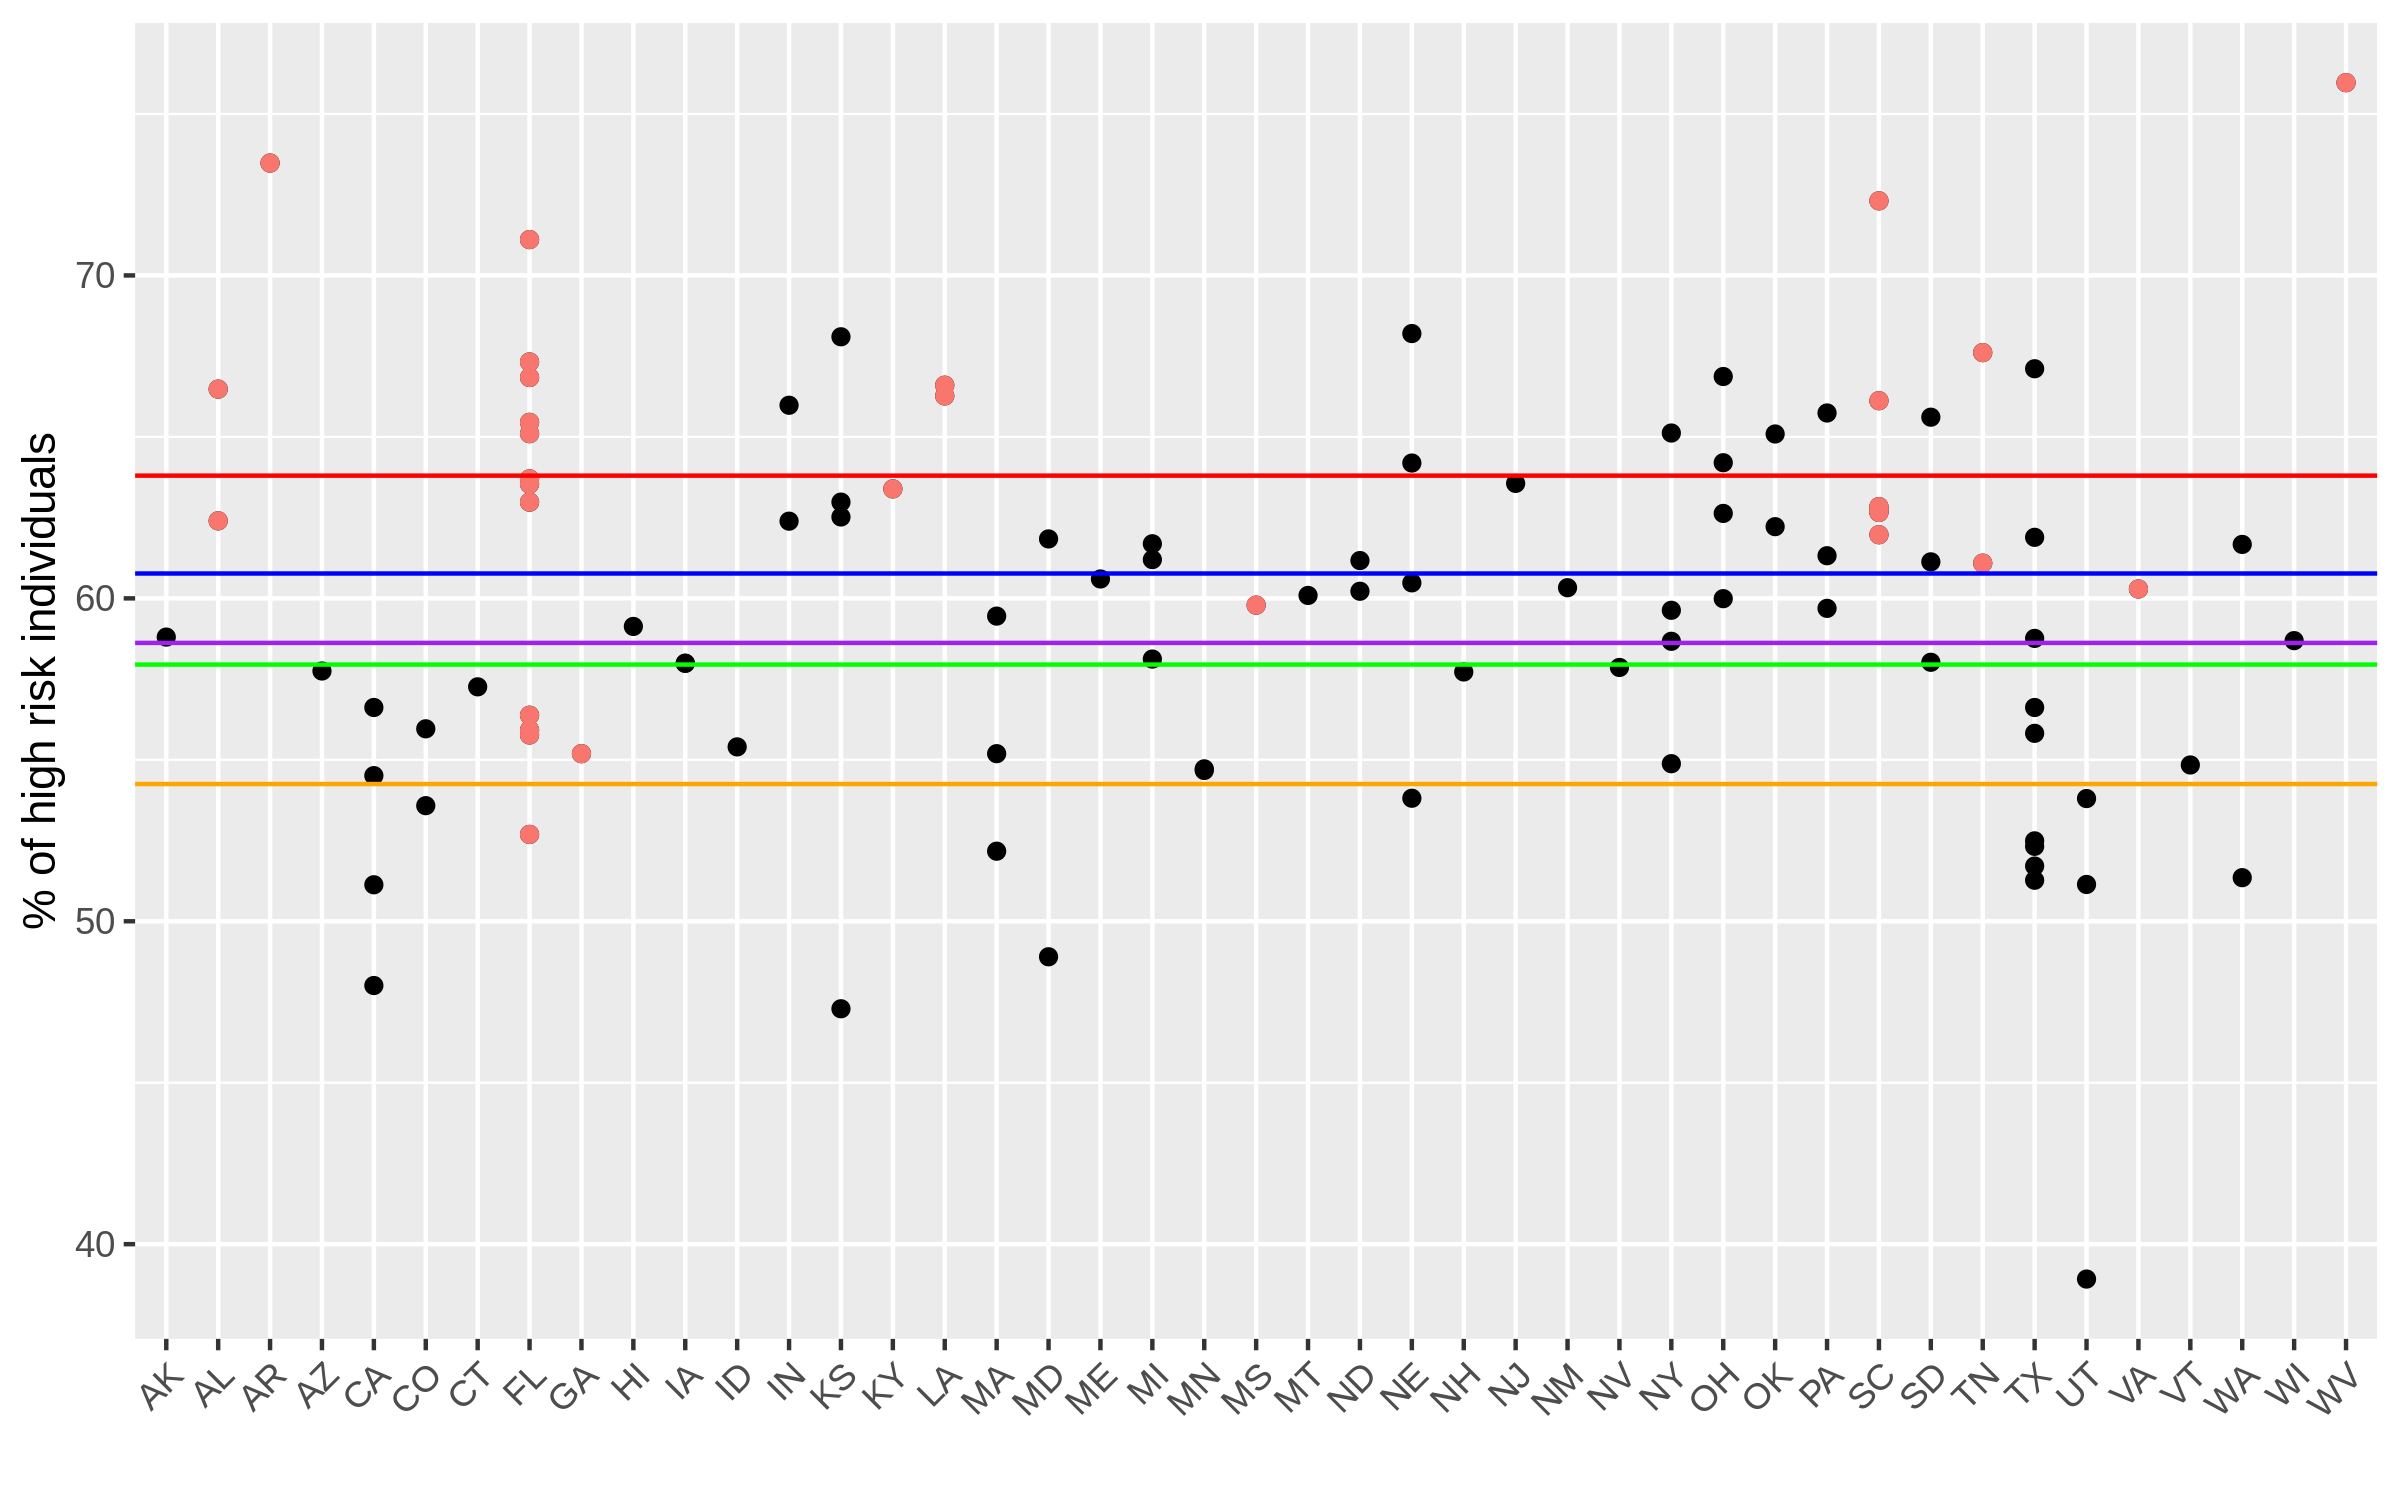

In [49]:
covid_rev %>% ggplot(., aes(x = State, y = total_percent_at_risk2)) + 
    geom_point() + 
    geom_point(data = region %>% filter(Region == "Southeast"), aes(color = Region)) +
    labs(y = "% of high risk individuals", x="") + 
    geom_hline(yintercept = 58.62, color = 'purple') + 
    geom_hline(yintercept = 57.95, color = 'green') + 
    geom_hline(yintercept = 60.77, color = 'blue') + 
    geom_hline(yintercept = 63.80, color = 'red') +
    geom_hline(yintercept = 54.25, color = 'orange') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), 
         legend.position = 'none')
# Averages are shown according to region: Northeast (purple), Southwest (green), Midwest (blue), Southeast (red), West (orange)"))


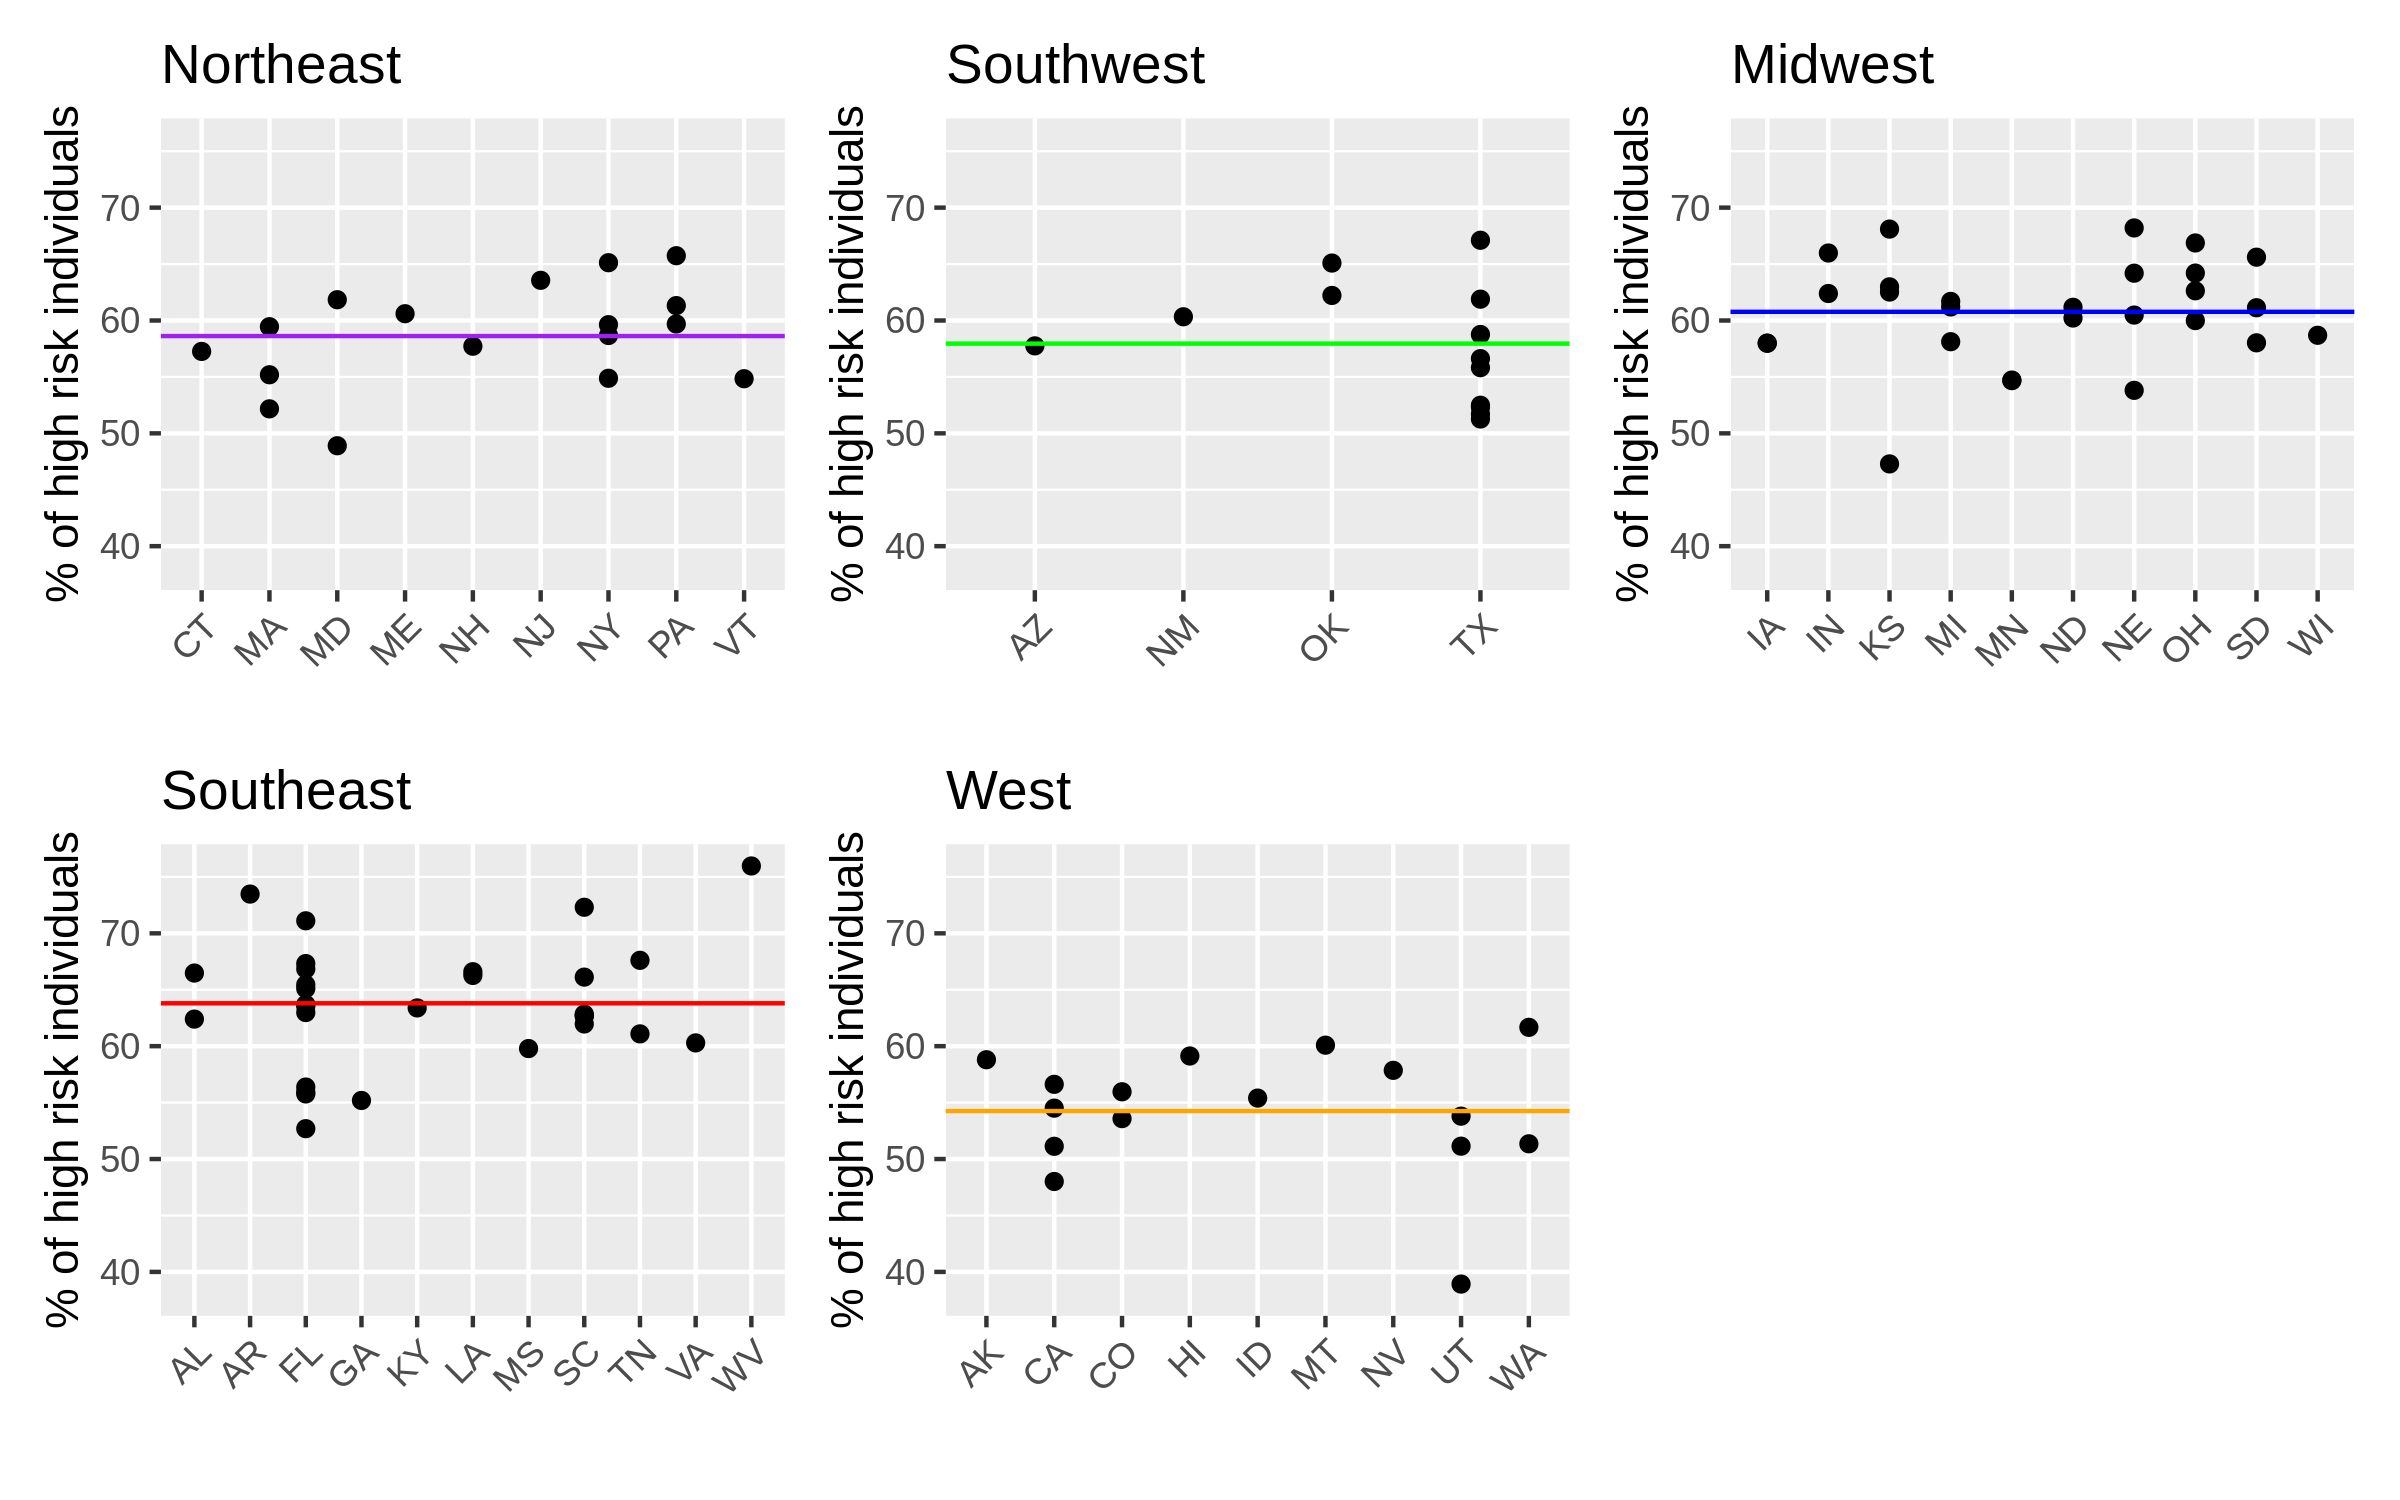

In [41]:
# plot of percentage at high risk by US region 
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res=300)

NE <- region %>% 
    filter(Region == "Northeast") %>% 
    group_by(State) %>% 
    ggplot(., aes(x = State, y = total_percent_at_risk2)) + 
        geom_point() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        geom_hline(yintercept = 58.62, color = 'purple') + 
        labs(y = "% of high risk individuals", x="") + 
        ggtitle("Northeast") + 
        ylim(38, 76)

SW <- region %>% 
    filter(Region == "Southwest") %>% 
    group_by(State) %>% 
    ggplot(., aes(x = State, y = total_percent_at_risk2)) + 
        geom_point() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        geom_hline(yintercept = 57.95, color = 'green') + 
        labs(y = "% of high risk individuals", x = "") + 
        ggtitle("Southwest") + 
        ylim(38, 76)

MW <- region %>% 
    filter(Region == "Midwest") %>% 
    group_by(State) %>% 
    ggplot(., aes(x = State, y = total_percent_at_risk2)) + 
        geom_point() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        geom_hline(yintercept = 60.77, color = 'blue') + 
        labs(y = "% of high risk individuals", x = "") + 
        ggtitle("Midwest") + 
        ylim(38, 76)

SE <- region %>% 
    filter(Region == "Southeast") %>% 
    group_by(State) %>% 
    ggplot(., aes(x = State, y = total_percent_at_risk2)) + 
        geom_point() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        geom_hline(yintercept = 63.80, color = 'red') + 
        labs(y = "% of high risk individuals", x = "") + 
        ggtitle("Southeast") + 
        ylim(38, 76)

W <- region %>% 
    filter(Region == "West") %>% 
    group_by(State) %>% 
    ggplot(., aes(x = State, y = total_percent_at_risk2)) + 
        geom_point() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        geom_hline(yintercept = 54.25, color = 'orange') + 
        labs(y = "% of high risk individuals", x = "") + 
        ggtitle("West") + 
        ylim(38, 76)

NE + SW + MW + SE + W

The six plots above show the percent of high risk individuals again, but with respect to region for easier comparison. In the first (large) plot, we see the highest average percentage of high risk individuals is among states in the Southeast, averaging 64%, followed by states in the midwest averaging 61%, states in the northeast averaging 59%, states in the southwest averaging 58%, and lastly, lastly, the region with the fewest high risk individuals include states in the west averaging 54%. These findings are consistent with the earlier findings since the three states we investigated (SC, WV, LA) are concentrated in the southeast. One other point to make here, is that this dataset included more MMSAs in the Southeast and Midwest, where we see the highest number of high risk individuals, while fewer MMSAs in the west and southwest, where we see lower numbers high risk individuals. The southwest region only included four states, and more than half of the MMSAs are located in Texas. 

State     | Percent | Color 
----------|---------|-------
Southeast | 63.80%  |red
Midwest   | 60.77%  |blue
Northeast | 58.62%  |purple
Southwest | 57.95%  |green
West      | 54.25%  |orange